In [693]:
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

In [694]:
df = pd.read_csv(
    "Building_Permits.csv", dtype={"Voluntary Soft-Story Retrofit": "object", "TIDF Compliance": "object"}
)

In [695]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Permit Number                           198900 non-null  object 
 1   Permit Type                             198900 non-null  int64  
 2   Permit Type Definition                  198900 non-null  object 
 3   Permit Creation Date                    198900 non-null  object 
 4   Block                                   198900 non-null  object 
 5   Lot                                     198900 non-null  object 
 6   Street Number                           198900 non-null  int64  
 7   Street Number Suffix                    2216 non-null    object 
 8   Street Name                             198900 non-null  object 
 9   Street Suffix                           196132 non-null  object 
 10  Unit                                    2947

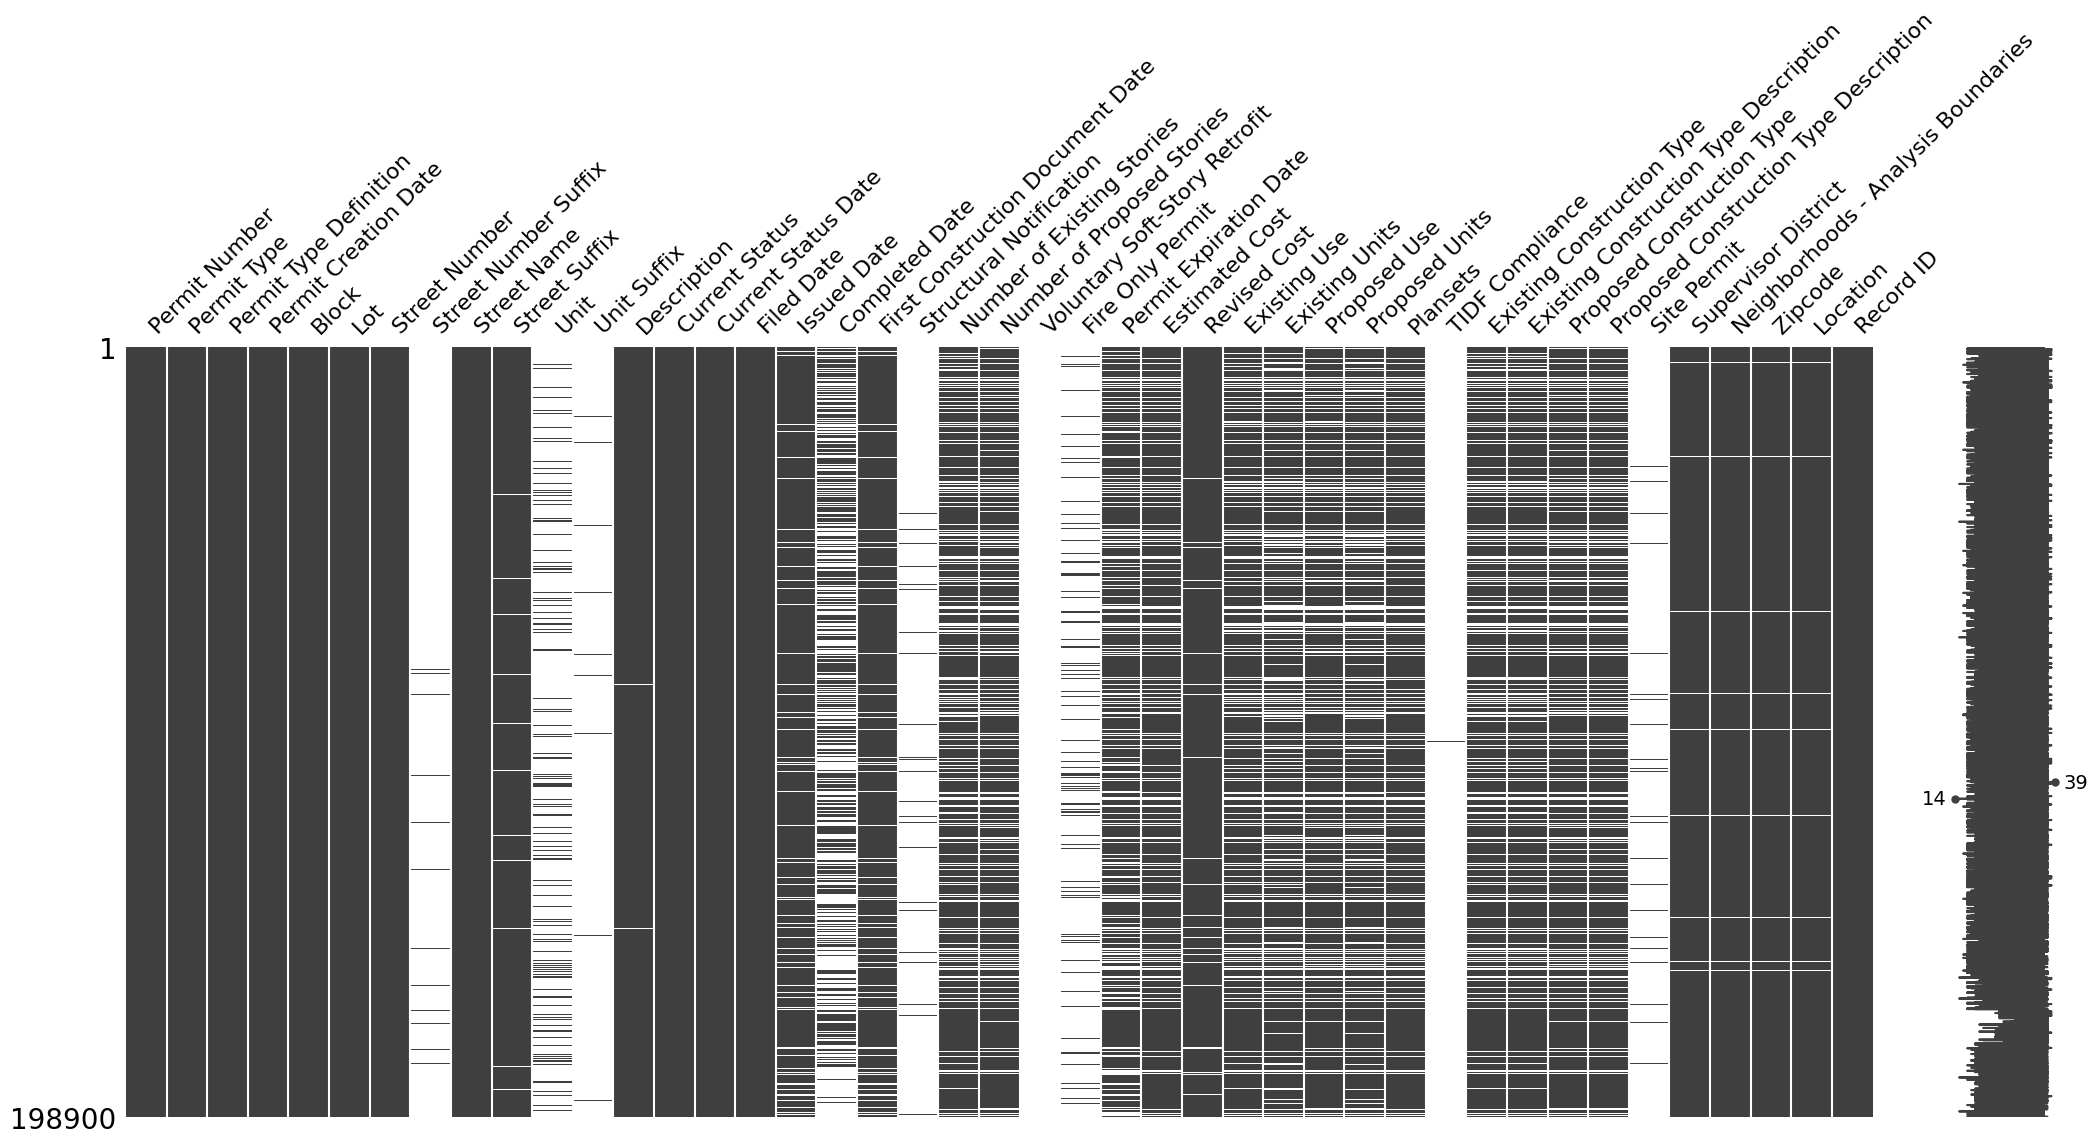

In [696]:
msno.matrix(df)
plt.show()

In [697]:
df = df.drop(columns=["TIDF Compliance", "Voluntary Soft-Story Retrofit", "Unit Suffix", "Street Number Suffix",
                      "Structural Notification", "Site Permit"])

In [698]:
df = df.dropna(
    subset=["Issued Date", "Number of Existing Stories", "Number of Proposed Stories", "Permit Expiration Date",
            "Estimated Cost", "Revised Cost", "Existing Units", "Proposed Units", "Plansets",
            "First Construction Document Date", "Existing Construction Type", "Supervisor District",
            "Neighborhoods - Analysis Boundaries", "Zipcode", ])

In [699]:
df = df.drop(
    columns=["Permit Number", "Permit Type Definition", "Block", "Lot", "Street Name", "Street Suffix", "Unit", "Description", "Current Status",
             "Current Status Date", "Completed Date", "Fire Only Permit", "Existing Use", "Existing Units",
             "Existing Construction Type Description", "Location", "Record ID", "Proposed Use"])

In [700]:
df = df.dropna()

In [701]:
cols = ['Filed Date', 'Issued Date']
df[cols] = df[cols].apply(pd.to_datetime, errors='coerce')

In [702]:
df['Permit Process Time'] = (df['Issued Date'] - df['Filed Date']).dt.days
df = df.drop(columns=['Filed Date', 'Issued Date', 'Permit Creation Date', 'Permit Expiration Date', 'First Construction Document Date'])

In [703]:
Q1 = df['Permit Process Time'].quantile(0.25)
Q3 = df['Permit Process Time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('Lower bound:', lower_bound)
print('Upper bound:', upper_bound)

Lower bound: -15.0
Upper bound: 25.0


In [704]:
lower_bound = 0

df = df[(df['Permit Process Time'] >= lower_bound) & (df['Permit Process Time'] <= upper_bound)]

In [705]:
df['Number of Existing Stories'] = df['Number of Existing Stories'].replace({1.5: 1, 2.5: 2})
df['Number of Proposed Stories'] = df['Number of Proposed Stories'].replace({1.5: 1, 2.5: 2})

In [706]:
Q1 = df['Number of Existing Stories'].quantile(0.25)
Q3 = df['Number of Existing Stories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print('Lower bound:', lower_bound)
print('Upper bound:', upper_bound)

Lower bound: -1.0
Upper bound: 7.0


In [707]:
lower_bound = 0

df = df[(df['Number of Existing Stories'] >= lower_bound) & (df['Number of Existing Stories'] <= upper_bound)]

In [708]:
Q1 = df['Number of Proposed Stories'].quantile(0.25)
Q3 = df['Number of Proposed Stories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound1 = Q1 - (1.5 * IQR)
upper_bound1 = Q3 + (1.5 * IQR)
print('Lower bound:', lower_bound1)
print('Upper bound:', upper_bound1)

Lower bound: 0.5
Upper bound: 4.5


In [709]:
lower_bound1 = 0

df = df[(df['Number of Proposed Stories'] >= lower_bound) & (df['Number of Proposed Stories'] <= upper_bound)]

In [710]:
df['Estimated Cost'] = df['Estimated Cost'].replace(0, np.nan)
df['Revised Cost'] = df['Revised Cost'].replace(0, np.nan)

df = df.dropna()

In [711]:
for col in ['Estimated Cost', 'Revised Cost']:
    df[col] = np.log(df[col])

In [712]:
Q1 = df['Proposed Units'].quantile(0.25)
Q3 = df['Proposed Units'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print('Lower bound:', lower_bound)
print('Upper bound:', upper_bound)

Lower bound: -2.0
Upper bound: 6.0


In [713]:
lower_bound = 0

df = df[(df['Proposed Units'] >= lower_bound) & (df['Proposed Units'] <= upper_bound)]

In [714]:
Q1 = df['Plansets'].quantile(0.25)
Q3 = df['Plansets'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
print('Lower bound:', lower_bound)
print('Upper bound:', upper_bound)

Lower bound: -3.0
Upper bound: 5.0


In [715]:
lower_bound = 0
df = df[(df['Plansets'] >= lower_bound) & (df['Plansets'] <= upper_bound)]

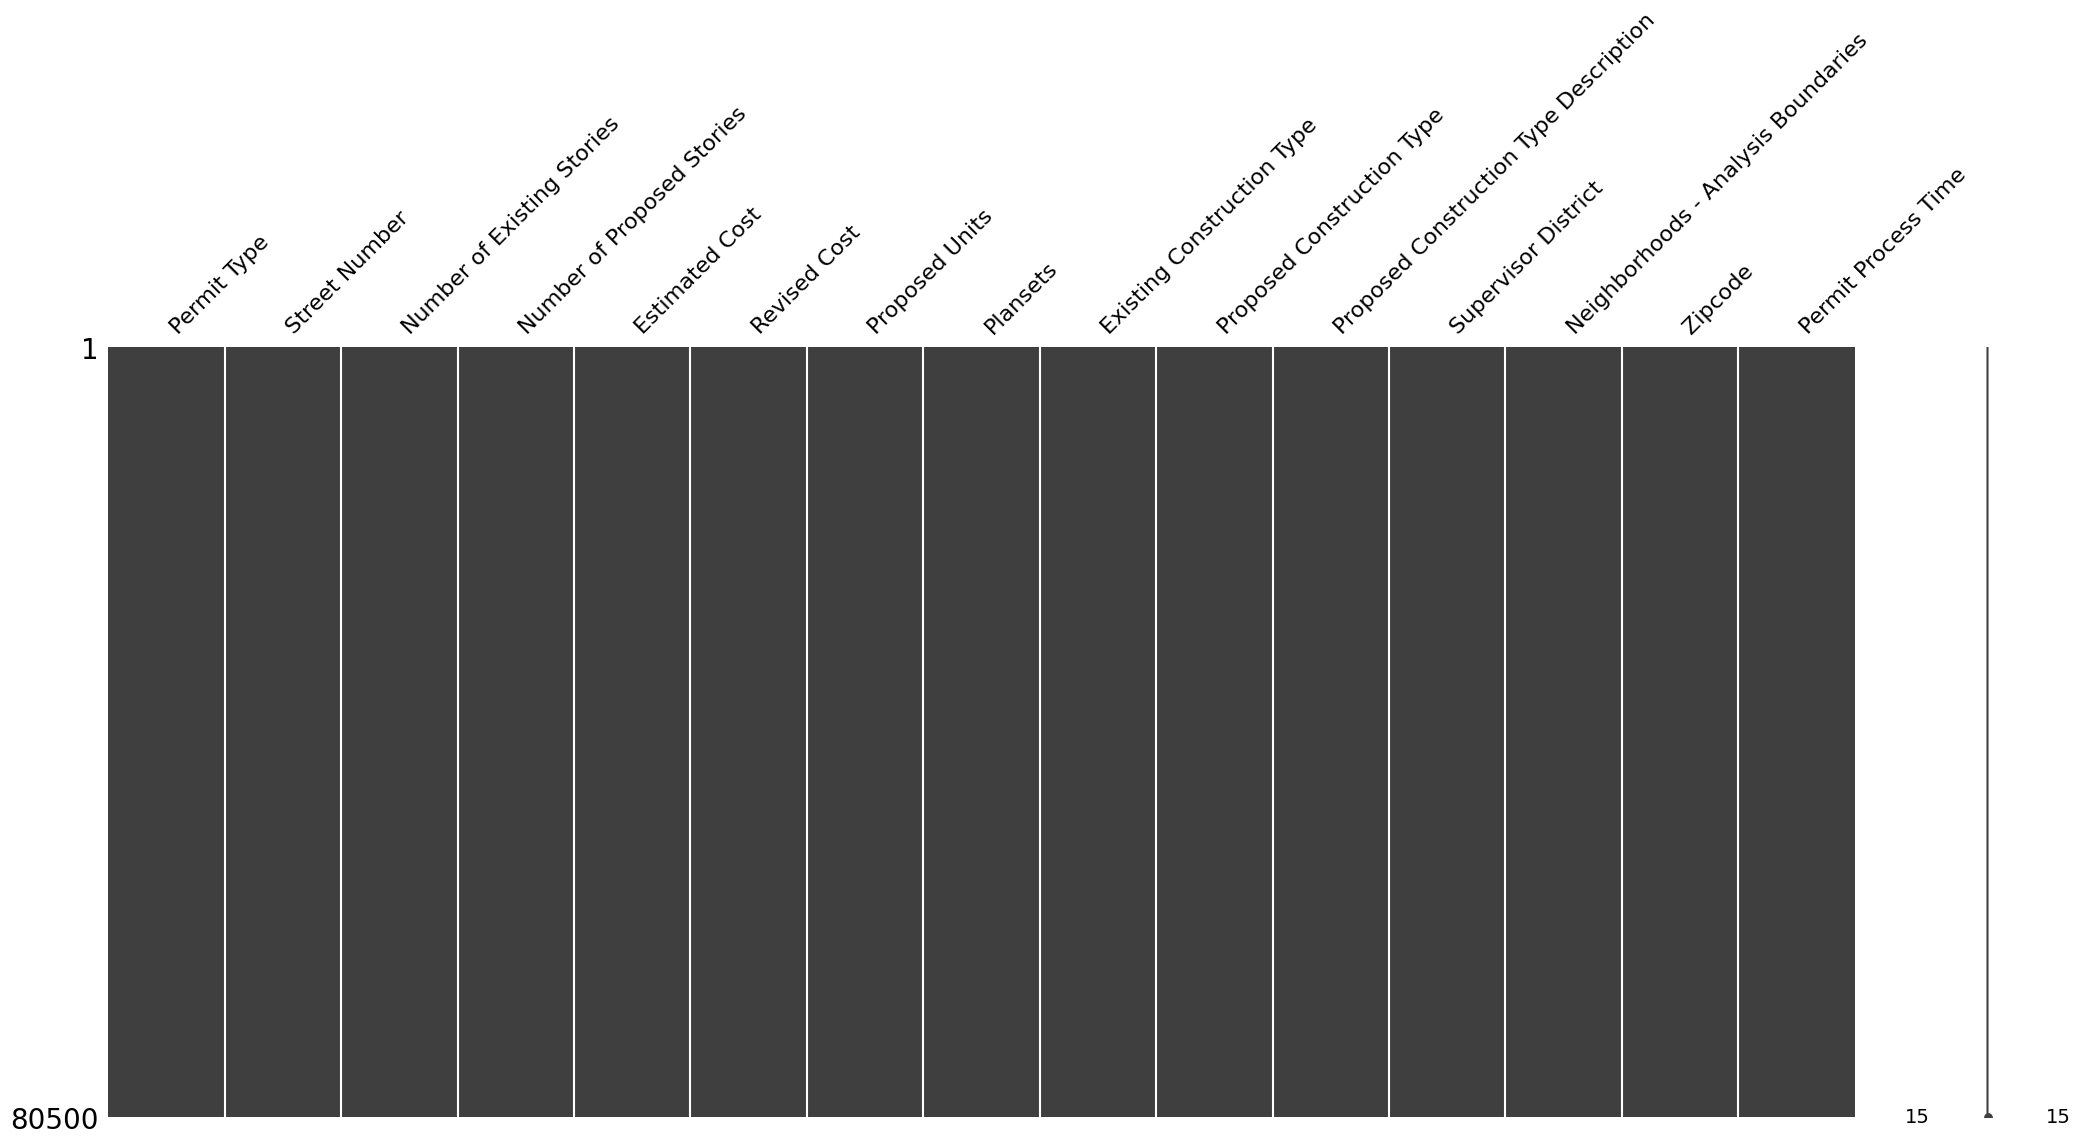

In [716]:
msno.matrix(df)
plt.show()

In [717]:
df_encoded = pd.get_dummies(
    df,
    columns=['Proposed Construction Type Description', 'Neighborhoods - Analysis Boundaries'],
    drop_first=True
)
X = df_encoded.drop(columns=['Permit Process Time'])
y = df_encoded['Permit Process Time']

In [718]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [719]:
y_train.describe()
y_train.value_counts()

Permit Process Time
0     39332
1      3490
3      1453
2      1397
4      1176
7      1173
6      1052
5      1005
8       725
14      550
13      501
9       460
11      454
12      434
10      426
21      378
15      365
20      289
16      255
17      249
18      238
22      236
19      222
25      172
23      167
24      151
Name: count, dtype: int64

In [720]:
sm = SMOTE(random_state=42)

X_train, y_train = sm.fit_resample(X_train, y_train)

In [721]:
X_train.head()

,Permit Type,Street Number,Number of Existing Stories,Number of Proposed Stories,Estimated Cost,Revised Cost,Proposed Units,Plansets,Existing Construction Type,Proposed Construction Type,...,Neighborhoods - Analysis Boundaries_Russian Hill,Neighborhoods - Analysis Boundaries_Seacliff,Neighborhoods - Analysis Boundaries_South of Market,Neighborhoods - Analysis Boundaries_Sunset/Parkside,Neighborhoods - Analysis Boundaries_Tenderloin,Neighborhoods - Analysis Boundaries_Treasure Island,Neighborhoods - Analysis Boundaries_Twin Peaks,Neighborhoods - Analysis Boundaries_Visitacion Valley,Neighborhoods - Analysis Boundaries_West of Twin Peaks,Neighborhoods - Analysis Boundaries_Western Addition
0,8,1167,4.0,4.0,8.006368,8.006368,0.0,2.0,3.0,3.0,...,False,False,True,False,False,False,False,False,False,False
1,8,1330,2.0,2.0,9.798127,9.798127,1.0,0.0,5.0,5.0,...,False,False,False,False,False,False,False,False,False,False
2,8,466,2.0,2.0,7.824046,7.824046,2.0,0.0,5.0,5.0,...,False,False,False,False,False,False,False,False,False,False
3,8,1910,2.0,2.0,9.510445,9.510445,2.0,0.0,5.0,5.0,...,False,False,False,False,False,False,False,False,False,False
4,8,3252,2.0,2.0,8.342840,7.313220,1.0,0.0,5.0,5.0,...,False,False,False,False,False,False,False,False,False,False


In [722]:
y_train.describe()
y_train.value_counts()

Permit Process Time
3     39332
0     39332
4     39332
1     39332
5     39332
7     39332
6     39332
20    39332
14    39332
24    39332
13    39332
8     39332
11    39332
12    39332
9     39332
16    39332
10    39332
21    39332
2     39332
25    39332
18    39332
22    39332
15    39332
19    39332
23    39332
17    39332
Name: count, dtype: int64

In [723]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False, header=True)

In [724]:
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False, header=True)